# Time series anaysis on FX market

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.unitroot import ADF
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Data precess

In [12]:
aud = pd.read_csv('/Users/klaus_zhangjt/Desktop/quant/FX/FX_TRI/AUD_v2.csv')
aud['tri'] = aud.tri.values + 50
aud['log_return'] = aud['tri'].apply(np.log).diff()
aud.dropna(how='any', inplace=True)
aud

,timestamp,underlyer,tri,spot,carry,active,version,log_return
1,1997-03-20 19:00:00,AUD,50.090012,0.089139,0.224690,True,v2,0.001799
2,1997-03-21 19:00:00,AUD,49.827164,-0.174776,0.198000,True,v2,-0.005261
3,1997-03-24 19:00:00,AUD,50.163459,0.160175,0.207871,True,v2,0.006727
4,1997-03-25 19:00:00,AUD,50.133008,0.129161,0.198581,True,v2,-0.000607
5,1997-03-26 19:00:00,AUD,49.511216,-0.500142,0.254483,True,v2,-0.012480
...,...,...,...,...,...,...,...,...
6496,2022-02-10 19:00:00,AUD,99.502538,-27.269520,-0.317250,True,v2,0.002759
6497,2022-02-11 19:00:00,AUD,98.711620,-28.066674,-0.420000,True,v2,-0.007980
6498,2022-02-14 19:00:00,AUD,98.196670,-28.595716,-0.383333,True,v2,-0.005230
6499,2022-02-15 19:00:00,AUD,98.706518,-28.075515,-0.385714,True,v2,0.005179


In [22]:
log_return = aud['log_return'].values
train_test_split = aud[aud.timestamp.str.contains('2019')].index[-1] + 1
train = log_return[:train_test_split]
test = log_return[train_test_split:]

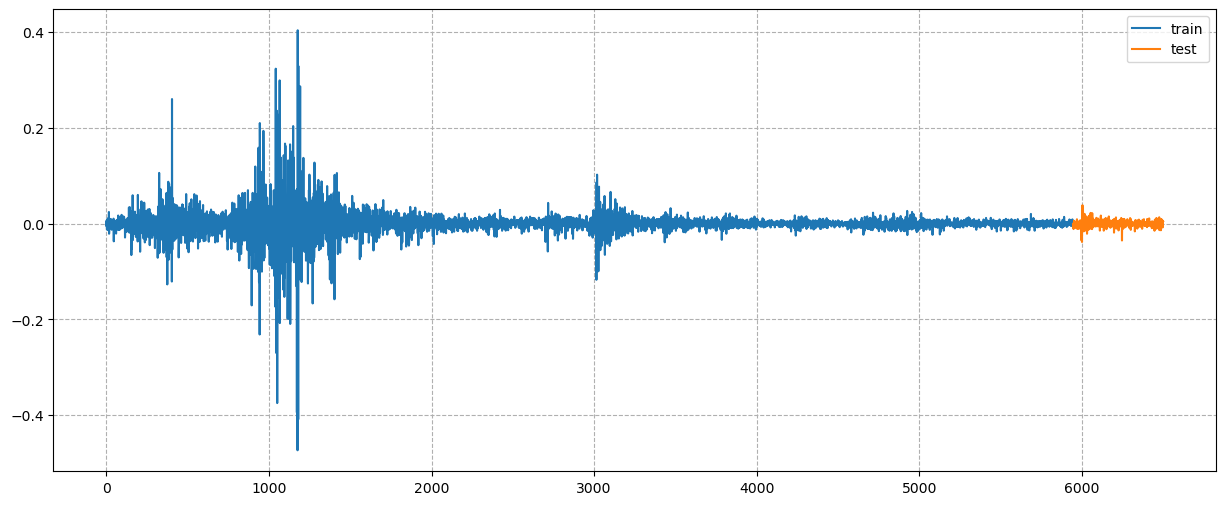

In [102]:
plt.figure(figsize=(15,6))
plt.plot(range(train_test_split), train, label='train')
plt.plot(range(train_test_split, len(aud)), test, label='test')
plt.legend()
plt.grid(linestyle='--')
plt.show()

## Hypothesis tests and visualization

In [103]:
adf = ADF(log_return)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -16.387
P-value                         0.000
Lags                               35
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [26]:
adf = ADF(test)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -5.406
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [107]:
from statsmodels.stats.diagnostic import acorr_ljungbox  
acorr_ljungbox(log_return, lags=[i for i in range(1,21)]) 

,lb_stat,lb_pvalue
1,30.394860,3.524609e-08
2,34.212607,3.722433e-08
3,143.265224,7.470724e-31
4,210.249295,2.348345e-44
5,226.225141,6.889873e-47
6,265.554091,1.938292e-54
7,265.614094,1.310084e-53
8,268.094990,2.496277e-53
9,286.021461,2.399158e-56
10,291.612616,9.204806e-57


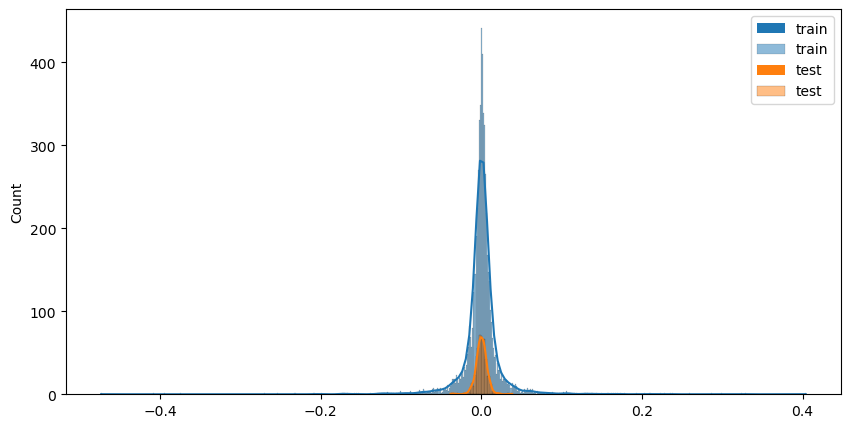

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(train, kde=True, label='train')
sns.histplot(test, kde=True, label='test')
plt.legend()
plt.show()

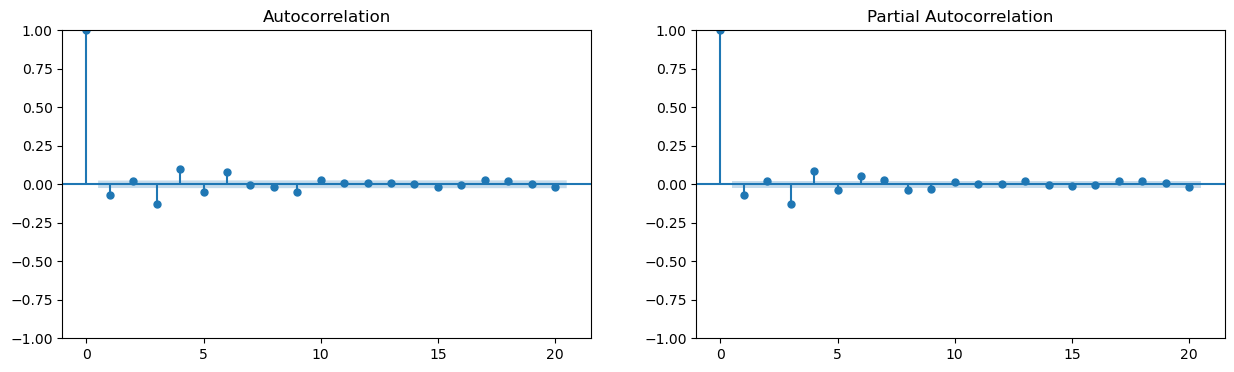

In [19]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
sm.graphics.tsa.plot_acf(log_return, lags=20, ax=axes[0])
sm.graphics.tsa.plot_pacf(log_return, lags=20, ax=axes[1], method='ywm')
plt.show()

## ARIMA model

In [93]:
p_list = [i for i in range(1,11)]
q_list = [i for i in range(1,11)]
aic_list = []
for p in p_list:
    for q in q_list:
        arima_model = ARIMA(train, order=(p, 0, q))
        arima_result = arima_model.fit()
        aic_list.append(arima_result.aic)

/Users/klaus_zhangjt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/klaus_zhangjt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/klaus_zhangjt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/klaus_zhangjt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

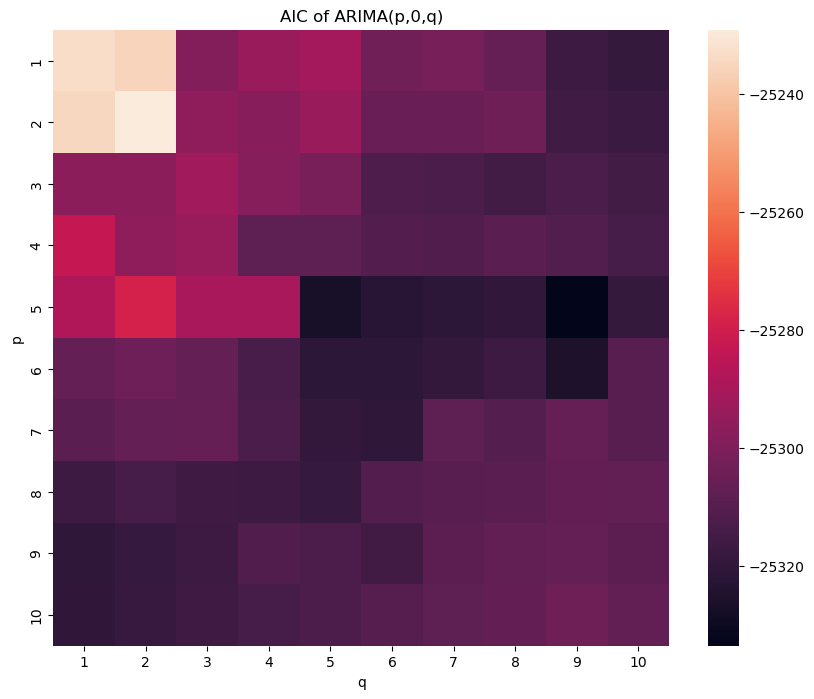

In [121]:
aic_list = np.array(aic_list).reshape((10,10))
df = pd.DataFrame(aic_list)
df.columns = q_list
df.index = p_list
plt.figure(figsize=(10,8))
sns.heatmap(data=df,square=True)#, annot=True) 
plt.xlabel('q')
plt.ylabel('p')
plt.title('AIC of ARIMA(p,0,q)')
plt.show()

In [101]:
arima_model = ARIMA(train, order=(5, 0, 5))
arima_result = arima_model.fit()
print(arima_result.summary())

/Users/klaus_zhangjt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5945
Model:                 ARIMA(5, 0, 5)   Log Likelihood               12675.475
Date:                Tue, 02 May 2023   AIC                         -25326.950
Time:                        13:59:46   BIC                         -25246.666
Sample:                             0   HQIC                        -25299.057
                               - 5945                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.281      0.779      -0.001       0.001
ar.L1         -0.5416      0.046    -11.891      0.000      -0.631      -0.452
ar.L2         -0.5834      0.030    -19.650      0.0

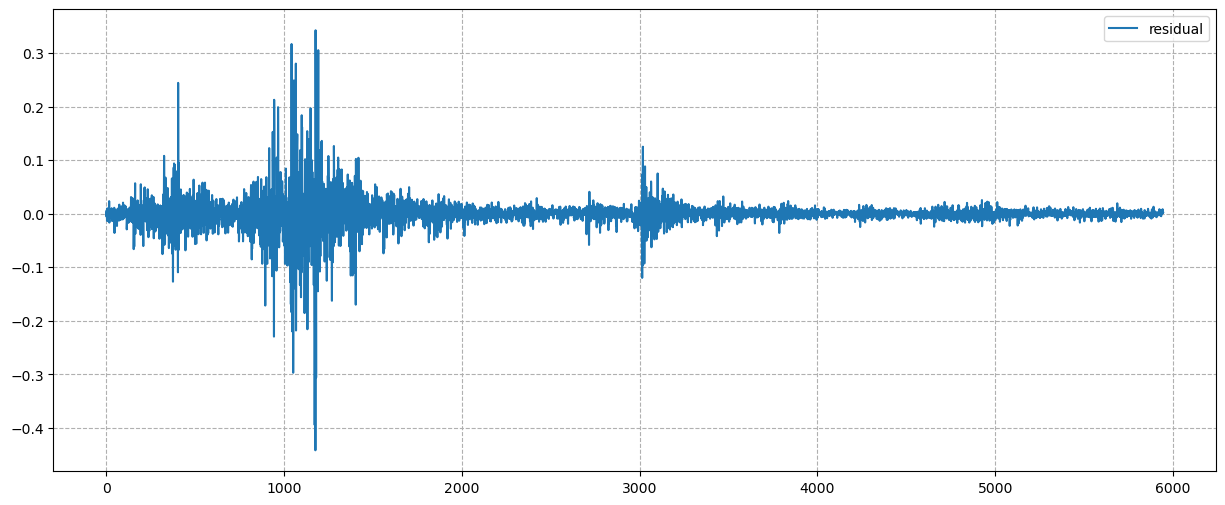

In [118]:
plt.figure(figsize=(15,6))
plt.plot(arima_result.resid, label='residual')
plt.legend()
plt.grid(linestyle='--')
plt.show()

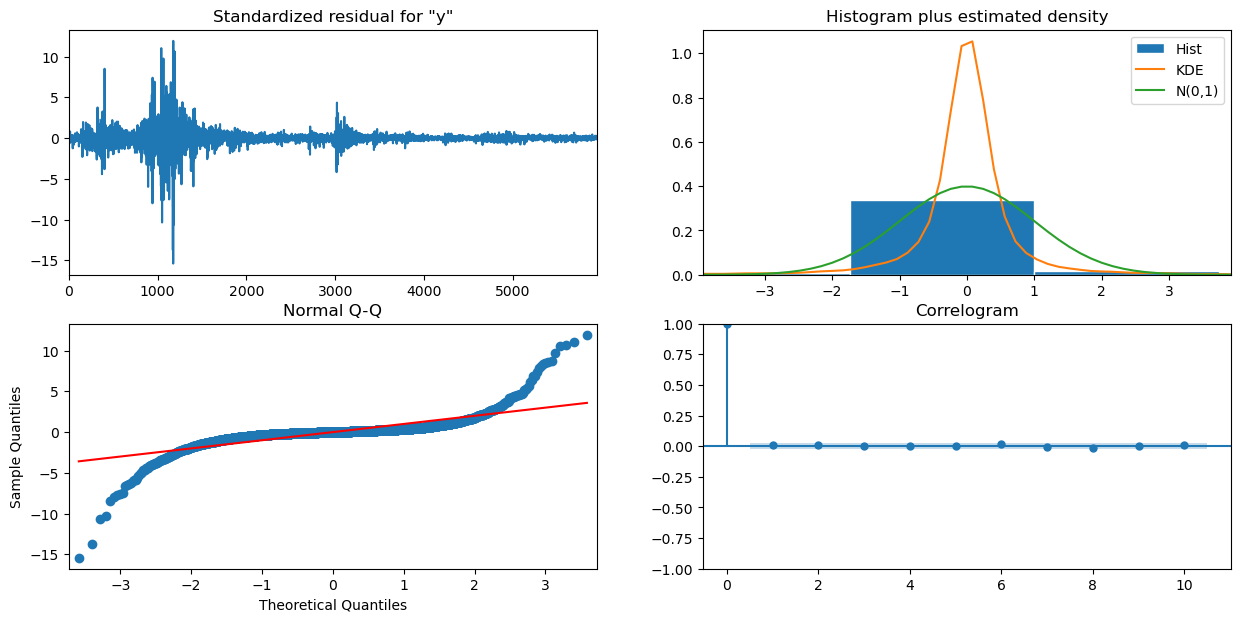

In [119]:
arima_result.plot_diagnostics(figsize=(15,7))
plt.show()

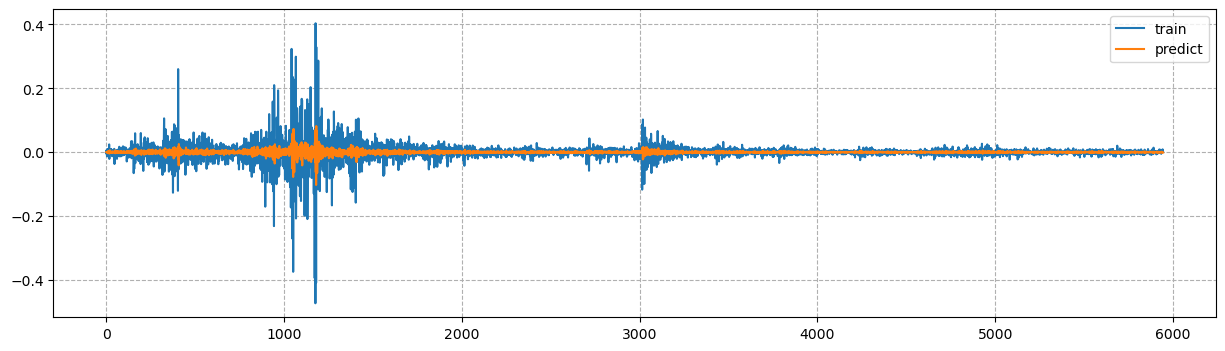

In [116]:
plt.figure(figsize=(15,4))
plt.plot(train, label='train')
plt.plot(arima_result.predict(), label='predict')
plt.legend()
plt.grid(linestyle='--')
plt.show()

In [143]:
at = arima_result.resid ** 2
acorr_ljungbox(at, lags=[i for i in range(1,21)])

,lb_stat,lb_pvalue
1,724.688343,1.279950e-159
2,1249.695814,4.285504e-272
3,1745.005039,0.000000e+00
4,3434.410211,0.000000e+00
5,4145.335504,0.000000e+00
6,4621.437025,0.000000e+00
7,4923.672302,0.000000e+00
8,5590.744524,0.000000e+00
9,6120.305620,0.000000e+00
10,6661.036150,0.000000e+00


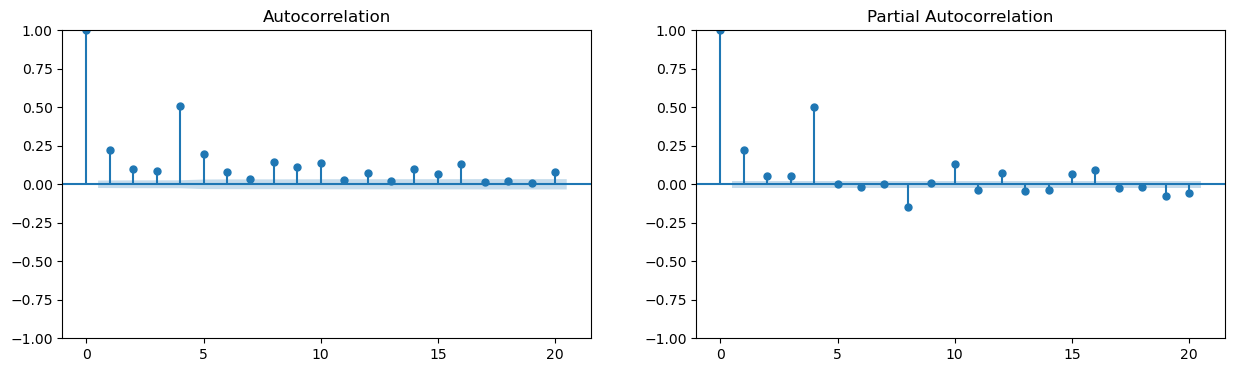

In [195]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
sm.graphics.tsa.plot_acf(at**2, lags=20, ax=axes[0])
sm.graphics.tsa.plot_pacf(at**2, lags=20, ax=axes[1], method='ywm')
plt.show()

In [133]:
predictions = []
interval_low, interval_up = [], []
for x in test:
    pred = arima_result.get_forecast(steps=1).summary_frame()
    predictions.append(pred.values[0][0])
    interval_low.append(pred.values[0][2])
    interval_up.append(pred.values[0][3])
    train = np.append(train, x)
    arima_model = ARIMA(train, order=(5, 0, 5))
    arima_result = arima_model.fit()

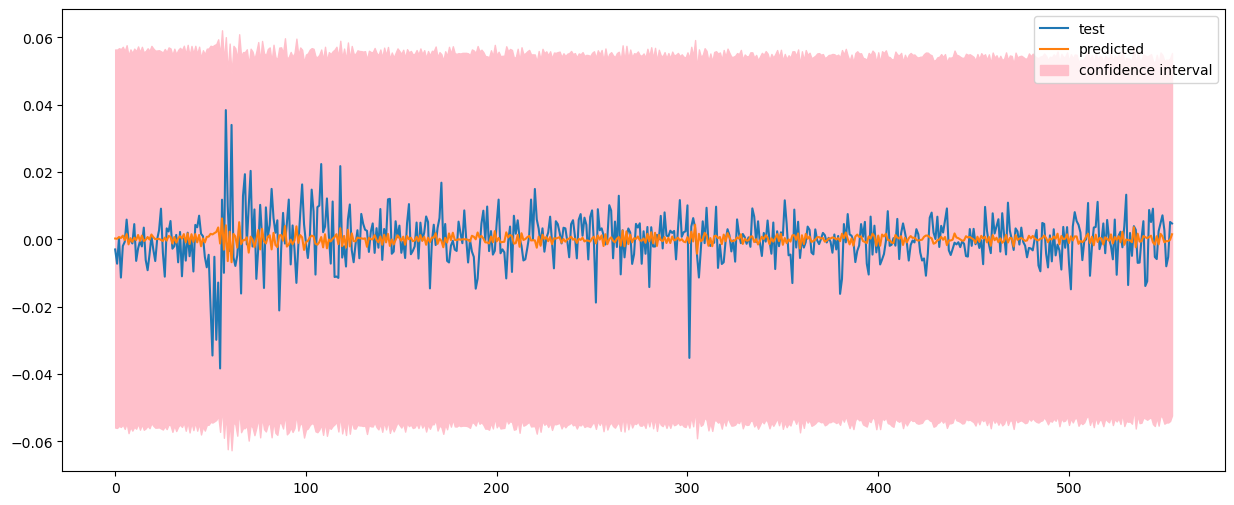

In [134]:
plt.figure(figsize=(15,6))
plt.plot(test, label='test')
plt.plot(predictions, label='predicted')
plt.fill_between(range(len(test)), interval_low, interval_up, color='pink', label='confidence interval')
plt.legend()
plt.show()

In [204]:
np.corrcoef(test[1:], predictions[:-1])[0][1]

-0.10398776917135706

In [147]:
mse = np.sqrt(mean_squared_error(test, predictions)) 
print('Correlation coefficient:', np.corrcoef(test, predictions)[0][1])
print(f'MSE: {mse:.5f}')

Correlation coefficient: -0.017855249634021846
MSE: 0.00740


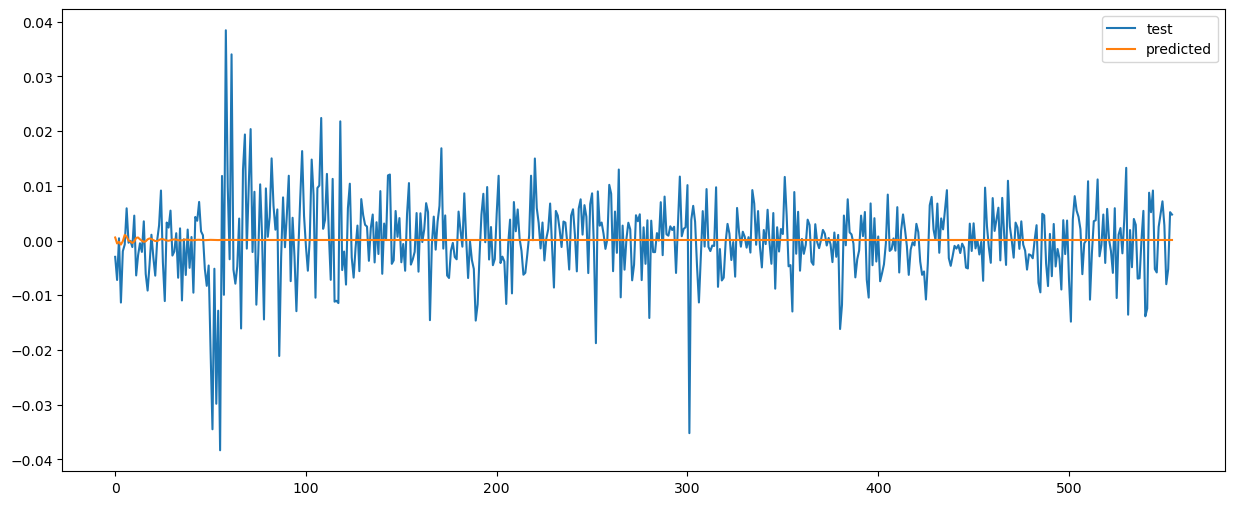

MSE: 0.00726


In [150]:
plt.figure(figsize=(15,6))
plt.plot(test, label='test')
plt.plot(arima_result.forecast(len(test)), label='predicted')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(test, arima_result.forecast(len(test))))
print(f'MSE: {rmse:.5f}')